In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.layers import Dense, Input, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, accuracy_score, mean_squared_error, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV, cross_val_score

from gaose.GAOSE import GAOSE

# 1 - Load dataset

In [3]:
features_3_sec = pd.read_csv('./Data/features_3_sec.csv')
#features_30_sec = pd.read_csv('./Data/features_30_sec.csv')
features_3_sec.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


# 2 - Pre-process data

In [39]:
features_3_sec = features_3_sec.sample(frac=1)

## 2.1 - Label encoding

In [40]:
filenames = features_3_sec.filename
X = features_3_sec.drop(columns=['filename', 'length', 'label'])
y = features_3_sec.label

encoder = LabelEncoder()
y = encoder.fit_transform(y)

## 2.2 - Scaling

In [41]:
scaler = StandardScaler()
X = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)
X.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var
0,-0.151282,0.316550,1.787246,0.836191,-0.223386,-0.702025,-0.301766,-0.617163,-0.246068,-0.534878,...,1.247761,0.612603,-0.201547,-0.741573,0.854851,-0.041109,-0.438200,0.369229,0.287257,0.880693
1,-0.070162,-0.053242,-0.797962,-0.286501,-0.800729,-0.582296,-0.292930,-0.236974,-0.527972,-0.196890,...,0.253711,-0.952779,-0.388752,-0.995447,0.814652,-0.934754,0.434915,-0.972264,-0.140700,-0.509913
2,0.124851,0.599404,0.169890,-0.372728,-0.818741,0.415051,0.034793,0.763316,-0.385683,0.977610,...,0.847147,-0.548183,0.187087,0.697755,-0.692183,1.315375,0.356906,1.366428,1.056634,0.518505
3,-0.237707,-0.212414,0.457546,-0.204633,0.165377,-0.266894,0.141491,-0.400189,0.260239,-0.220585,...,0.717357,-0.471570,-0.419634,-0.534617,1.924393,-0.188778,-0.772221,-0.385745,0.014071,-0.670368
4,-0.704731,0.550977,-1.218640,-0.627567,-1.693176,-0.913770,-2.078330,-0.916863,-1.804735,-1.010289,...,-1.673302,0.000270,-0.239894,0.284664,-0.374488,-0.563138,0.607952,0.067401,-0.429431,0.354533


In [42]:
y

array([0, 9, 9, ..., 6, 1, 9])

In [51]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
str(len(X_train)) + ' ' + str(len(X_test))

'6993 2997'

# 3 - Cross-validation evaluation
## 3.1 - KNN

In [46]:
knn_params = [
    {'nn': 2, 'w': 'distance', 'p': 1},
    {'nn': 3, 'w': 'distance', 'p': 1},
    {'nn': 5, 'w': 'distance', 'p': 1},
    {'nn': 3, 'w': 'uniform', 'p': 1},
    {'nn': 2, 'w': 'distance', 'p': 2},
]

knn_res = []

for param in knn_params:
    (nn, w, p) = param.values()
    print(nn, w, p)
    knn_model = KNeighborsClassifier(
        n_neighbors=nn, weights=w, p=p
    )
    cv_acc = cross_val_score(knn_model, X, y, cv=5)
    knn_res.append([nn, w, p, sum(cv_acc) / 5])
    print(cv_acc)
    print(param)
    
knn_res_df = pd.DataFrame(data=knn_res, columns=['nn', 'w', 'p', 'cv_acc'])
knn_res_df = knn_res_df.sort_values('cv_acc', ascending=False)
knn_res_df.head()
    

2 distance 1
[0.93643644 0.92892893 0.93543544 0.93343343 0.93443443]
{'nn': 2, 'w': 'distance', 'p': 1}
3 distance 1
[0.92992993 0.92742743 0.92592593 0.92942943 0.92742743]
{'nn': 3, 'w': 'distance', 'p': 1}
5 distance 1
[0.92092092 0.91491491 0.91941942 0.92592593 0.91941942]
{'nn': 5, 'w': 'distance', 'p': 1}
3 uniform 1
[0.92492492 0.91641642 0.91891892 0.92192192 0.91891892]
{'nn': 3, 'w': 'uniform', 'p': 1}
2 distance 2
[0.90690691 0.90890891 0.90540541 0.91941942 0.91291291]
{'nn': 2, 'w': 'distance', 'p': 2}


,nn,w,p,cv_acc
0,2,distance,1,0.933734
1,3,distance,1,0.928028
3,3,uniform,1,0.920220
2,5,distance,1,0.920120
4,2,distance,2,0.910711


## 3.2 - SVM

In [47]:
svm_params = [
    {'kernel': 'poly', 'gamma': 10, 'C': 1},
    {'kernel': 'poly', 'gamma': 10, 'C': 10},
    {'kernel': 'poly', 'gamma': 10, 'C': 100},
    {'kernel': 'poly', 'gamma': 100, 'C': 1},
    {'kernel': 'poly', 'gamma': 100, 'C': 10},
]
svm_res = []

for param in svm_params:
    (k, g, c) = param.values()
    print(k, g, c)
    svm_model = SVC(kernel=k, gamma=g, C=c)
    cv_acc = cross_val_score(svm_model, X, y, cv=5)
    svm_res.append([k, g, c, sum(cv_acc) / 5])
    print(cv_acc)
    print(param)
    
svm_res_df = pd.DataFrame(data=svm_res, columns=['k', 'g', 'c', 'cv_acc'])
svm_res_df = svm_res_df.sort_values('cv_acc', ascending=False)
svm_res_df.head()

poly 10 1
[0.9034034  0.8983984  0.9024024  0.90740741 0.9009009 ]
{'kernel': 'poly', 'gamma': 10, 'C': 1}
poly 10 10
[0.9034034  0.8983984  0.9024024  0.90740741 0.9009009 ]
{'kernel': 'poly', 'gamma': 10, 'C': 10}
poly 10 100
[0.9034034  0.8983984  0.9024024  0.90740741 0.9009009 ]
{'kernel': 'poly', 'gamma': 10, 'C': 100}
poly 100 1
[0.9034034  0.8983984  0.9024024  0.90740741 0.9009009 ]
{'kernel': 'poly', 'gamma': 100, 'C': 1}
poly 100 10
[0.9034034  0.8983984  0.9024024  0.90740741 0.9009009 ]
{'kernel': 'poly', 'gamma': 100, 'C': 10}


,k,g,c,cv_acc
0,poly,10,1,0.902503
1,poly,10,10,0.902503
2,poly,10,100,0.902503
3,poly,100,1,0.902503
4,poly,100,10,0.902503


## 3.3 - Random Forest

In [49]:
rf_params = [
    {'criterion': 'gini', 'n_est': 800, 'mf': 'sqrt'},
    {'criterion': 'entropy', 'n_est': 600, 'mf': 'sqrt'},
    {'criterion': 'entropy', 'n_est': 500, 'mf': 'sqrt'},
    {'criterion': 'entropy', 'n_est': 800, 'mf': 'sqrt'},
    {'criterion': 'gini', 'n_est': 700, 'mf': 'sqrt'},
]
rf_res = []

for param in rf_params:
    (crit, n_est, mf) = param.values()
    print(crit, n_est, mf)
    rf_model = RandomForestClassifier(
        criterion=crit,
        max_features=mf,
        n_estimators=n_est
    )
    cv_acc = cross_val_score(rf_model, X, y, cv=5)
    rf_res.append([crit, n_est, mf, sum(cv_acc) / 5])
    print(cv_acc)
    print(param)
    
rf_res_df = pd.DataFrame(data=rf_res, columns=['crit', 'nest', 'mf', 'cv_acc'])
rf_res_df = rf_res_df.sort_values('cv_acc', ascending=False)
rf_res_df.head()

gini 800 sqrt
[0.8958959  0.86436436 0.87837838 0.88138138 0.86936937]
{'criterion': 'gini', 'n_est': 800, 'mf': 'sqrt'}
entropy 600 sqrt
[0.8978979  0.86686687 0.87937938 0.88388388 0.87237237]
{'criterion': 'entropy', 'n_est': 600, 'mf': 'sqrt'}
entropy 500 sqrt
[0.8958959  0.86486486 0.88338338 0.88488488 0.87637638]
{'criterion': 'entropy', 'n_est': 500, 'mf': 'sqrt'}
entropy 800 sqrt
[0.8978979  0.86786787 0.87937938 0.87887888 0.87587588]
{'criterion': 'entropy', 'n_est': 800, 'mf': 'sqrt'}
gini 700 sqrt
[0.8988989  0.86036036 0.88338338 0.88538539 0.87137137]
{'criterion': 'gini', 'n_est': 700, 'mf': 'sqrt'}


,crit,nest,mf,cv_acc
2,entropy,500,sqrt,0.881081
1,entropy,600,sqrt,0.880080
3,entropy,800,sqrt,0.879980
4,gini,700,sqrt,0.879880
0,gini,800,sqrt,0.877878


# 4 - GAOSE

In [87]:
gaose = GAOSE(models=[
    KNeighborsClassifier(n_neighbors=2, weights='distance', p=1),
    SVC(kernel='poly', gamma=10, C=1),
    RandomForestClassifier(criterion='entropy', n_estimators=500, max_features='sqrt'),
    #KNeighborsClassifier(n_neighbors=3, weights='distance', p=1),
    #SVC(kernel='poly', gamma=10, C=100),
    #KNeighborsClassifier(n_neighbors=3, weights='uniform', p=1),
], n_classes=10, pInstances=1, pFeatures=1)

gaose.fit(X_train, y_train, pop_size=30, max_epochs=3000)

[1] - Training weak learners
[2] - Optimizing weights


0.9012345679012346


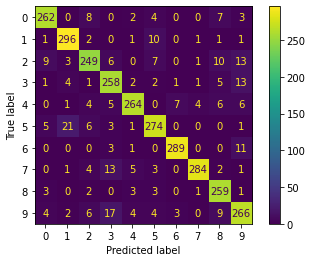

In [88]:
gaose_predictions = gaose.predict(X_test)
print(accuracy_score(y_test, gaose_predictions))
cm = confusion_matrix(y_test, gaose_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

Como é possível cocluir, o algoritmo GAOSE não consegue obter melhores resultados comparativamente com os algoritmos já testados.